In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow import lite

# Connect to Google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing of the images
We will be training a VGG-19 model on our custom training dataset to classify among the 5 categories-Phoma, Cescospora, Rust, Healthy, and Miners. The dataset must all be resized to the required dimension.

While resizing the images, let us also derive x_train,x_test,x_val,y_train,y_test and y_val hand-in-hand. These terms can be described in a nutshell as follows:

- **x_train**: Numpy arrays of the images of the training dataset
- **y_train**: Labels of the training dataset
- **x_test**: Numpy arrays of the images of the testing dataset
- **y_test**: Labels of the testing dataset
- **x_val**: Numpy arrays of the images of the validation dataset
- **y_val**: Labels of the validation dataset

In [6]:
# /content/drive/MyDrive/Capstone Co-ffee/Dataset3

train_path="./drive/MyDrive/Capstone Co-ffee/Dataset3/train"
test_path="./drive/MyDrive/Capstone Co-ffee/Dataset3/test"
val_path="./drive/MyDrive/Capstone Co-ffee/Dataset3/val"

In [7]:
IMG_SIZE = (128,128)

# def is_img_empty(img):
#   if type(img) is np.ndarray:
#     if img.size == 0:
#       return True
#   if img is None:
#     return True

# def pre_proc_images(file_path):
#     file_list=[]
#     for folder in os.listdir(file_path):
#         sub_path=file_path+"/"+folder
#         for img in os.listdir(sub_path):
#             image_path=sub_path+"/"+img
#             img_arr=cv2.imread(image_path)
#             if is_img_empty(img_arr):
#               print(f'This file is corrupt, You must delete this file:\n{image_path}')
#               continue
#             img_arr=cv2.resize(img_arr,IMG_SIZE)
#             file_list.append(img_arr)
#     norm_file = np.array(file_list)/255.0
#     return norm_file

def ImgDataGen(file_path,f=True):
    if f:    
      file_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=30,
                      horizontal_flip=True,
                      width_shift_range = 0.2,
                      height_shift_range = 0.2,
                      shear_range = 0.1,
                      #validation_split = 0.4,
                      fill_mode = 'nearest'
                      )
    else:
      file_datagen = ImageDataGenerator(rescale=1./255)
  
    file_set = file_datagen.flow_from_directory(file_path,
                                                target_size = IMG_SIZE,
                                                shuffle = f,
                                                batch_size = 32,
                                                class_mode = 'categorical')
    return file_set


In [8]:
# train_x, test_x, val_x = pre_proc_images(train_path), pre_proc_images(test_path), pre_proc_images(val_path)
training_set, test_set, val_set = ImgDataGen(train_path), ImgDataGen(test_path,f=False), ImgDataGen(val_path)

Found 8194 images belonging to 5 classes.
Found 1175 images belonging to 5 classes.
Found 2340 images belonging to 5 classes.


In [9]:
# train_y, test_y, val_y = training_set.classes, test_set.classes, val_set.classes
# train_y.shape,test_y.shape,val_y.shape
# train_x.shape,test_x.shape,val_x.shape
training_set.class_indices

{'Cerscospora': 0, 'Healthy': 1, 'Leaf rust': 2, 'Miner': 3, 'Phoma': 4}

# Training using VGG16

In [10]:
vgg = VGG16(input_shape= [128,128] + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [11]:
for layer in vgg.layers:
    layer.trainable = False

In [12]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [16]:
# fit the model
history = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/20
257/257 [==============================] - 1503s 6s/step - loss: 0.2710 - accuracy: 0.9131 - val_loss: 0.1201 - val_accuracy: 0.9654
Epoch 2/20
257/257 [==============================] - 61s 237ms/step - loss: 0.1042 - accuracy: 0.9721 - val_loss: 0.0764 - val_accuracy: 0.9795
Epoch 3/20
257/257 [==============================] - 60s 234ms/step - loss: 0.0681 - accuracy: 0.9824 - val_loss: 0.0634 - val_accuracy: 0.9855
Epoch 4/20
257/257 [==============================] - 61s 236ms/step - loss: 0.0597 - accuracy: 0.9841 - val_loss: 0.0418 - val_accuracy: 0.9936
Epoch 5/20
257/257 [==============================] - 60s 234ms/step - loss: 0.0501 - accuracy: 0.9863 - val_loss: 0.0391 - val_accuracy: 0.9906
Epoch 6/20
257/257 [==============================] - 60s 233ms/step - loss: 0.0371 - accuracy: 0.9900 - val_loss: 0.0374 - val_accuracy: 0.9885
Epoch 7/20
257/257 [==============================] - 61s 236ms/step - loss: 0.0332 - accuracy: 0.9918 - val_loss: 0.0268 - val_acc

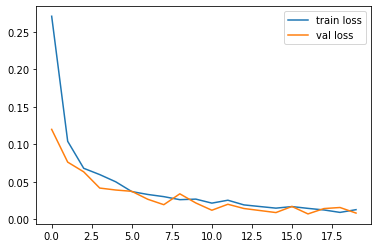

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

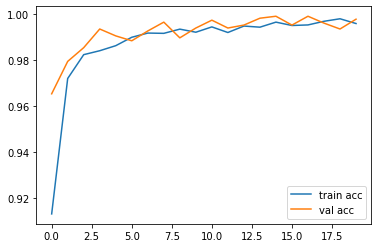

In [18]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [19]:
model.evaluate(test_set,batch_size=32)

37/37 [==============================] - 198s 5s/step - loss: 0.0056 - accuracy: 0.9983


[0.00564358476549387, 0.9982978701591492]

In [20]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import numpy as np

In [21]:
y_pred=model.predict(test_set)
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_set.classes)


0.9982978723404256

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00       168
           3       1.00      0.99      1.00       342
           4       0.98      1.00      0.99       131

    accuracy                           1.00      1175
   macro avg       1.00      1.00      1.00      1175
weighted avg       1.00      1.00      1.00      1175



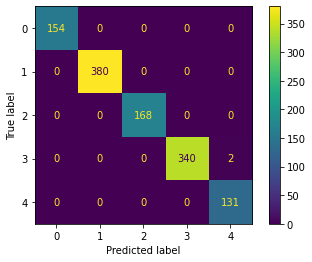

{'Cerscospora': 0, 'Healthy': 1, 'Leaf rust': 2, 'Miner': 3, 'Phoma': 4}


In [22]:
print(classification_report(y_pred,test_set.classes))

cm = confusion_matrix(y_pred,test_set.classes)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(test_set.class_indices)

# Export the Model

Save model

In [23]:
keras_file = "Augmented_VGG16.h5"
tf.keras.models.save_model(model,keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open("Augmented_VGG16.tflite","wb").write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmptnwrj3qg/assets


59030532

Save history

In [25]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

save to google drive

In [24]:
save_path = "./drive/MyDrive/Capstone Co-ffee/"
!cp -r './Augmented_VGG16.h5' save_path
!cp -r './Augmented_VGG16.tflite' save_path